# ML Binary Classification


## Setup


In [1]:
import datasets
import nltk
from nltk import sent_tokenize
import torch
import os
import seaborn as sns
import transformers
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    Trainer,
    DataCollatorWithPadding,
    TrainingArguments,
)
import matplotlib.pyplot as plt
import numpy as np
import evaluate
import random

nltk.download("punkt")

[nltk_data] Downloading package punkt to /home/016854656/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
os.environ["TOKENIZERS_PARALLELISM"] = "True"

In [3]:
ds = datasets.load_dataset("sem_eval_2020_task_11", data_dir="./datasets")
ds

DatasetDict({
    train: Dataset({
        features: ['article_id', 'text', 'span_identification', 'technique_classification'],
        num_rows: 371
    })
    test: Dataset({
        features: ['article_id', 'text', 'span_identification', 'technique_classification'],
        num_rows: 90
    })
    validation: Dataset({
        features: ['article_id', 'text', 'span_identification', 'technique_classification'],
        num_rows: 75
    })
})

In [4]:
def preprocess(ds: dict):
    items = []
    for entry in ds:
        text: str = entry["text"]
        spans = list(
            zip(
                entry["technique_classification"]["start_char_offset"],
                entry["technique_classification"]["end_char_offset"],
            )
        )
        newline_split = text.split("\n")

        for line in newline_split:
            # figure out where the line is
            tokenized_line = sent_tokenize(line)
            for tokenized_sentence in tokenized_line:
                assert type(tokenized_sentence) == str
                index = text.index(tokenized_sentence)

                is_classified = False
                for i in range(len(tokenized_sentence)):
                    for span in spans:
                        if span[0] <= index + i <= span[1]:
                            # mark it as true
                            is_classified = True
                            break

                items.append((tokenized_sentence, is_classified))
    return items


train_preprocessed = preprocess(ds["train"])
validation_preprocessed = preprocess(ds["validation"])
test_preprocessed = preprocess(ds["test"])

In [5]:
ds["test"][0]

{'article_id': 'article813452859',
 'text': "EU Profits From Trading With UK While London Loses Money – Political Campaigner\n\nWith the Parliamentary vote on British Prime Minister Theresa May’s Brexit plan set to be held next month; President of the European Commission Jean Claude Juncker has criticised the UK’s preparations for their departure from the EU.\nBut is there any chance that May's deal will make it through parliament and if it fails, how could this ongoing political deadlock finally come to an end?\nSputnik spoke with political campaigner Michael Swadling for more…\nSputnik: Does Theresa May have any chance of getting her deal through Parliament on the 14th January?\nMichael Swadling: I guess her only chance is if Labour decides that they want to dishonour democracy and effectively keep us in the EU.\n© AP Photo / Pablo Martinez Monsivais UK 'In Need of Leadership', May's Brexit Deal Unwelcome to Trump - US Ambassador\nThere is a chance; as unfortunately there are many MP

## Dataset Configuration


In [6]:
MIN_LENGTH = 60  # minimum number of characters per sentence


def cap(ds: list):
    temp = []
    for entry in ds:
        if len(entry[0]) >= MIN_LENGTH:
            temp.append(entry)
    return temp


train_preprocessed = cap(train_preprocessed)
validation_preprocessed = cap(validation_preprocessed)
test_preprocessed = cap(test_preprocessed)

Trues: 0.31921876250700393, Falses: 0.6807812374929961


([<matplotlib.patches.Wedge at 0x7fdd614a6250>,
 [Text(0.5916872047743914, 0.927311302479522, 'True'),
  Text(-0.5916872047743919, -0.9273113024795218, 'False')])

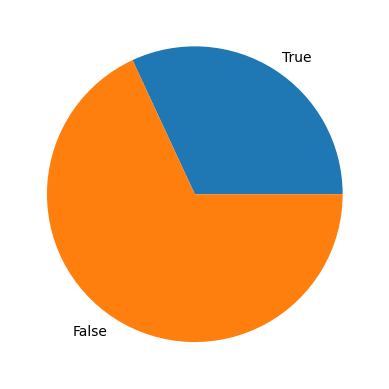

In [7]:
def make_plots(ds: list):
    labels = [label for _, label in ds]
    trues, falses = labels.count(True), labels.count(False)
    print(f"Trues: {trues/len(labels)}, Falses: {falses/len(labels)}")
    return plt.pie([trues, falses], labels=["True", "False"])


make_plots(train_preprocessed)

Trues: 0.2811529933481153, Falses: 0.7188470066518847


([<matplotlib.patches.Wedge at 0x7fdd613780d0>,
 [Text(0.6980917169311117, 0.8500987911720453, 'True'),
  Text(-0.6980916373391155, -0.8500988565321054, 'False')])

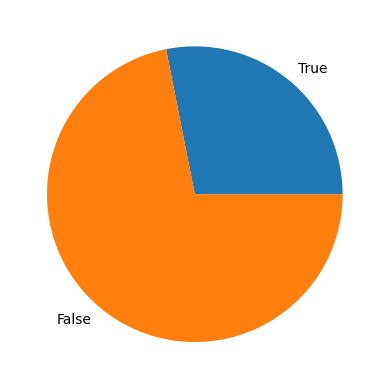

In [8]:
make_plots(validation_preprocessed)

Trues: 0.38247011952191234, Falses: 0.6175298804780877


([<matplotlib.patches.Wedge at 0x7fdd60f5a890>,
 [Text(0.39698817450927326, 1.02586567800068, 'True'),
  Text(-0.39698817450927315, -1.02586567800068, 'False')])

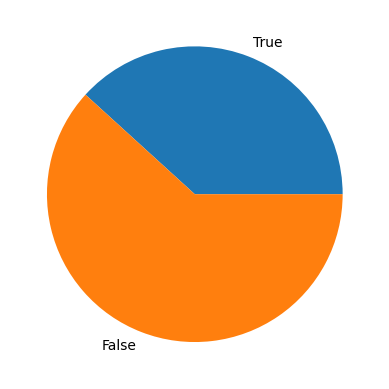

In [9]:
make_plots(test_preprocessed)

## Balance Dataset

new length is 7976
Trues: 0.5, Falses: 0.5


([<matplotlib.patches.Wedge at 0x7fdd60ff80d0>,
 [Text(6.735557395310444e-17, 1.1, 'True'),
  Text(-2.0206672185931328e-16, -1.1, 'False')])

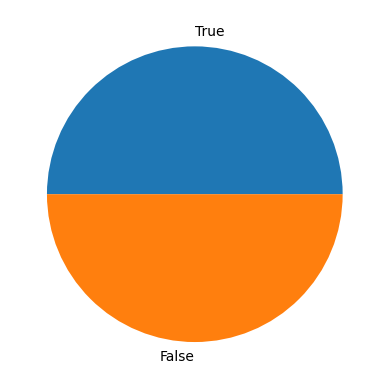

In [10]:
def balance(ds):
    trues = list(filter(lambda pair: pair[1], ds))
    falses=  list(filter(lambda pair: not pair[1], ds))
    n_trues = len(trues)
    assert len(trues) + len(falses) == len(ds)
    # make falses = trues
    new_falses = random.sample(falses, k=len(trues))
    assert len(new_falses) == len(trues)
    reconstructed_ds = trues
    reconstructed_ds.extend(new_falses)
    assert len(reconstructed_ds) == 2*n_trues
    random.shuffle(reconstructed_ds)
    return reconstructed_ds

train_balanced = balance(train_preprocessed)
print("new length is", len(train_balanced))
make_plots(train_balanced)   

In [11]:
train_balanced[0]

('“In what can only be described as a “WTF video” the following footage seems to literally show a team of unknown soldiers gearing up next to a helicopter near the Route 91 concert.”',
 True)

## Setup Model Workflow


In [12]:
model_name = 'xlm-roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Format Dataset


In [13]:
train = datasets.Dataset.from_dict(
    {
        "text": [sentence for sentence, _ in train_balanced],
        "labels": [1 if label else 0 for _, label in train_balanced],
    }
)
validation = datasets.Dataset.from_dict(
    {
        "text": [sentence for sentence, _ in validation_preprocessed],
        "labels": [1 if label else 0 for _, label in validation_preprocessed],
    }
)
test = datasets.Dataset.from_dict(
    {
        "text": [sentence for sentence, _ in test_preprocessed],
        "labels": [1 if label else 0 for _, label in test_preprocessed],
    }
)

In [14]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)


train = train.map(preprocess_function)
validation = validation.map(preprocess_function)
test = test.map(preprocess_function)

Map:   0%|          | 0/7976 [00:00<?, ? examples/s]

Map:   0%|          | 0/2255 [00:00<?, ? examples/s]

Map:   0%|          | 0/2510 [00:00<?, ? examples/s]

## Training Args and Training


In [15]:
collator = DataCollatorWithPadding(tokenizer)

In [16]:
metrics = evaluate.combine(["accuracy", "recall", "precision", "f1"])
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    return metrics.compute(predictions=predictions, references=labels)

In [17]:
args = TrainingArguments(
    num_train_epochs=6,
    output_dir="./balanced3",
    per_device_train_batch_size=12,
    per_device_eval_batch_size=12,
    weight_decay=0.007,
    learning_rate=5e-5,
    evaluation_strategy="steps",
    eval_steps=600,
    logging_steps=50,
    warmup_steps=100,
    gradient_accumulation_steps=3,
    lr_scheduler_type="cosine",
    save_steps=600
)

In [18]:
trainer = Trainer(
    model,
    args=args,
    data_collator=collator,
    train_dataset=train,
    eval_dataset=validation,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [19]:
trainer.train()

wandb: Currently logged in as: chrehall68. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
600,0.375100,0.546812,0.759202,0.785489,0.550276,0.647173
1200,0.066100,0.945818,0.774723,0.746057,0.576829,0.650619


Checkpoint destination directory ./balanced3/checkpoint-600 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./balanced3/checkpoint-1200 already exists and is non-empty. Saving will proceed but saved results may be invalid.


TrainOutput(global_step=1326, training_loss=0.32433491127163755, metrics={'train_runtime': 287.4063, 'train_samples_per_second': 166.51, 'train_steps_per_second': 4.614, 'total_flos': 2000967798233280.0, 'train_loss': 0.32433491127163755, 'epoch': 5.98})

In [20]:
predictions = trainer.predict(test)
metrics.compute(predictions = np.argmax(predictions.predictions, axis=-1), references=predictions.label_ids)

{'accuracy': 0.7326693227091633,
 'recall': 0.6822916666666666,
 'precision': 0.6415279138099902,
 'f1': 0.6612821807168097}

In [21]:
n_nonzero = np.argmax(predictions.predictions, axis=-1).nonzero()[0]
n_nonzero

array([   2,    5,    7, ..., 2500, 2501, 2505])

<Axes: >

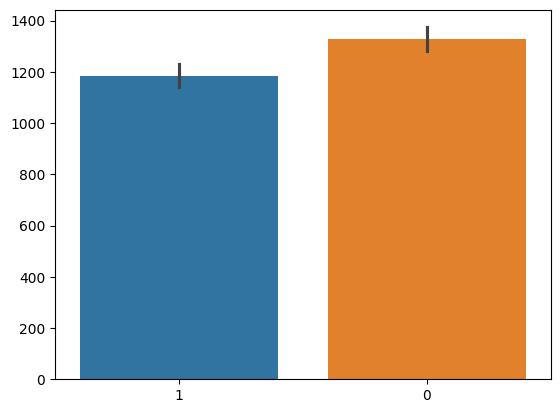

In [22]:
sns.barplot({"1":n_nonzero, "0":predictions.predictions.shape[0]-n_nonzero})

In [23]:
random_benchmark = [random.randint(0, 1) for _ in range(len(test))]
metrics.compute(random_benchmark, test['labels'])

{'accuracy': 0.4852589641434263,
 'recall': 0.50625,
 'precision': 0.3726993865030675,
 'f1': 0.42932862190812715}

In [35]:
trainer.save_model("iteration_balanced_v3")

In [25]:
def eval(sentence:str):
    with torch.no_grad():
        outputs = model(**tokenizer(sentence, return_tensors='pt').to('cuda'))
    print(outputs.logits)
    print(torch.argmax(outputs.logits, dim=-1))


In [26]:
eval("A is a dumb stupid letter.")

tensor([[-2.7304,  2.8549]], device='cuda:0')
tensor([1], device='cuda:0')


In [27]:
eval("A is the first letter in the alphabet.")

tensor([[ 2.7942, -3.0530]], device='cuda:0')
tensor([0], device='cuda:0')


In [28]:
eval("Join us today and be part of a movement dedicated to creating a brighter future for generations to come.")

tensor([[-0.2870,  0.5351]], device='cuda:0')
tensor([1], device='cuda:0')


In [29]:
eval("The new WHO finding will shock you")

tensor([[-2.5241,  2.6705]], device='cuda:0')
tensor([1], device='cuda:0')


In [30]:
eval("Dogs have pawsss.")

tensor([[0.1190, 0.1003]], device='cuda:0')
tensor([0], device='cuda:0')


In [31]:
eval("Dogs have paws.")

tensor([[ 1.9900, -2.0646]], device='cuda:0')
tensor([0], device='cuda:0')


In [32]:
eval('the sky is blue.')

tensor([[ 2.9264, -3.1086]], device='cuda:0')
tensor([0], device='cuda:0')


In [33]:
eval('The WHO visited Geneva yesterday due to Covid-19.')

tensor([[ 2.9350, -3.1491]], device='cuda:0')
tensor([0], device='cuda:0')


In [36]:
# token = "" # huggingface token here
# model.push_to_hub("chreh/persuasive_language_detector", token=token, private=False, revision="roberta")

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/chreh/persuasive_language_detector/commit/581cf0e64700e7e093ccfbd2279d11d965eaae62', commit_message='Upload XLMRobertaForSequenceClassification', commit_description='', oid='581cf0e64700e7e093ccfbd2279d11d965eaae62', pr_url=None, pr_revision=None, pr_num=None)